<a href="https://colab.research.google.com/github/AS190-web/Pneumonia-Detection-Project-using-basic-DL-Concept-and-Kaggle-Datasets/blob/main/Pneumonia_Detection_System_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "pneumonia_mnist",
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
)
LABELS = ds_info.features['label'].names
print("Labels:", LABELS)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.HBRPOI_1.0.0/pneumonia_mnist-train.tfrecord*...…

Generating val examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.HBRPOI_1.0.0/pneumonia_mnist-val.tfrecord*...: …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/pneumonia_mnist/incomplete.HBRPOI_1.0.0/pneumonia_mnist-test.tfrecord*...:…

Dataset pneumonia_mnist downloaded and prepared to /root/tensorflow_datasets/pneumonia_mnist/1.0.0. Subsequent calls will reuse this data.
Labels: ['Normal', 'Pneumonia']


In [ ]:
IMG_SIZE = (64, 64)
BATCH = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    image = tf.reshape(image, [IMG_SIZE[0], IMG_SIZE[1], 1])
    return image, label

train_ds = ds_train.map(preprocess).shuffle(512).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# Collect test images/labels to numpy arrays for evaluation/plots
imgs_list, y_list = [], []
for imgs, labs in test_ds:
    imgs_list.append(imgs.numpy())
    y_list.append(labs.numpy())
imgs_all = np.concatenate(imgs_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
N = len(y_all)
print("Test set size:", N)

Test set size: 624


In [ ]:
def build_simple_cnn():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def resnet_block(x, filters, kernel=3):
    y = tf.keras.layers.Conv2D(filters, kernel, padding='same', activation='relu')(x)
    y = tf.keras.layers.Conv2D(filters, kernel, padding='same')(y)
    y = tf.keras.layers.Add()([x, y])
    y = tf.keras.layers.Activation('relu')(y)
    return y

def build_resnet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    # small residual block
    x = resnet_block(x, 32)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def dense_block(x, filters):
    # simple dense block: conv -> concat
    y = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    out = tf.keras.layers.Concatenate()([x, y])
    return out

def build_densenet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(inp)
    x = dense_block(x, 16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = dense_block(x, 32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_vgg_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def inception_module(x, filters):
    # tiny inception-like module
    p1 = tf.keras.layers.Conv2D(filters, 1, padding='same', activation='relu')(x)
    p2 = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    p3 = tf.keras.layers.Conv2D(filters, 5, padding='same', activation='relu')(x)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    p4 = tf.keras.layers.Conv2D(filters, 1, padding='same', activation='relu')(p4)
    return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

def build_inception_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(inp)
    x = inception_module(x, 16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = inception_module(x, 32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
models = {
    'SimpleCNN': build_simple_cnn(),
    'ResNetLike': build_resnet_like(),
    'DenseNetLike': build_densenet_like(),
    'VGGLike': build_vgg_like(),
    'InceptionLike': build_inception_like()
}

# Print summaries briefly
for name, m in models.items():
    print(f"\n--- {name} ---")
    m.summary()



--- SimpleCNN ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,225 (8.07 MB)

 Trainable params: 2,116,225 (8.07 MB)

 Non-trainable params: 0 (0.00 B)


--- ResNetLike ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │    524,352 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 543,233 (2.07 MB)

 Trainable params: 543,233 (2.07 MB)

 Non-trainable params: 0 (0.00 B)


--- DenseNetLike ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      2,320 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 32)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      9,248 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ max_pooling2d_4[… │
│ (Concatenate)       │ 64)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,953 (62.32 KB)

 Trainable params: 15,953 (62.32 KB)

 Non-trainable params: 0 (0.00 B)


--- VGGLike ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,162,401 (8.25 MB)

 Trainable params: 2,162,401 (8.25 MB)

 Non-trainable params: 0 (0.00 B)


--- InceptionLike ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │        272 │ conv2d_12[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │      2,320 │ conv2d_12[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      6,416 │ conv2d_12[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │        272 │ max_pooling2d_7[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_13[0][0],  │
│ (Concatenate)       │ 64)               │            │ conv2d_14[0][0],  │
│                     │                   │            │ conv2d_15[0][0],  │
│                     │                   │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ concatenate_2[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ max_pooling2d_8[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │      2,080 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     18,464 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     51,232 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │      2,080 │ max_pooling2d_9[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ conv2d_17[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_18[0][0],  │
│                     │                   │            │ conv2d_19[0][0],  │
│                     │                   │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 91,617 (357.88 KB)

 Trainable params: 91,617 (357.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 2
histories = {}
for name, model in models.items():
    print(f"\nTraining {name} for {EPOCHS} epochs...")
    histories[name] = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose=1)


Training SimpleCNN for 2 epochs...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - accuracy: 0.8325 - loss: 0.3813 - val_accuracy: 0.8478 - val_loss: 0.5178
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 217ms/step - accuracy: 0.9424 - loss: 0.1568 - val_accuracy: 0.8365 - val_loss: 0.4767

Training ResNetLike for 2 epochs...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.7771 - loss: 0.4732 - val_accuracy: 0.8285 - val_loss: 0.5216
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.9310 - loss: 0.1864 - val_accuracy: 0.8654 - val_loss: 0.4606

Training DenseNetLike for 2 epochs...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.7214 - loss: 0.5960 - val_accuracy: 0.6250 - val_loss: 0.6828
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.7447 - loss: 0.5457 - val_accuracy: 0.6250 - val_loss: 0.6221

Training VGGLike for 2 epochs...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 116s 769ms/step - accuracy: 0.8145 

In [ ]:
probs_dict = {}
accs = {}
for name, model in models.items():
    probs = model.predict(imgs_all, batch_size=64, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_all, preds)
    probs_dict[name] = probs
    accs[name] = acc
    print(f"{name} accuracy (0.5): {acc:.4f}")

ensemble_probs = np.mean(np.stack(list(probs_dict.values()), axis=0), axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)
ensemble_acc = accuracy_score(y_all, ensemble_preds)
print(f"\nEnsemble (avg probs) accuracy (0.5): {ensemble_acc:.4f}")

SimpleCNN accuracy (0.5): 0.8365
ResNetLike accuracy (0.5): 0.8654
DenseNetLike accuracy (0.5): 0.6250
VGGLike accuracy (0.5): 0.8478
InceptionLike accuracy (0.5): 0.6250

Ensemble (avg probs) accuracy (0.5): 0.8349


Ensemble ROC AUC: 0.9199


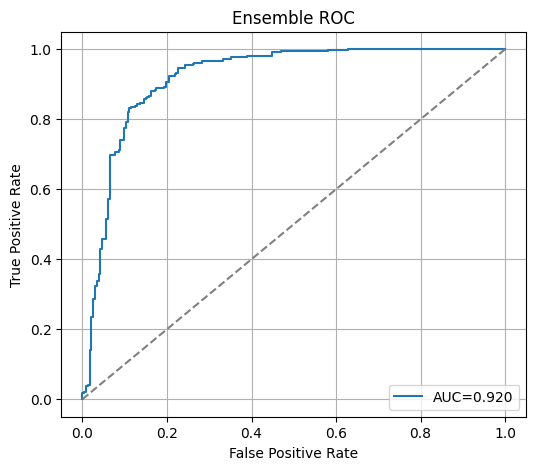

In [ ]:
fpr, tpr, thr = roc_curve(y_all, ensemble_probs)
roc_auc = auc(fpr, tpr)
print(f"Ensemble ROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC')
plt.legend(); plt.grid(True); plt.show()

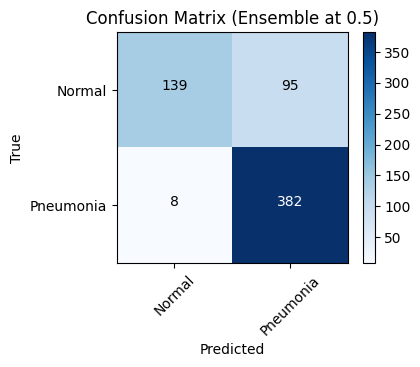

In [ ]:
cm = confusion_matrix(y_all, ensemble_preds)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0,1], LABELS, rotation=45)
plt.yticks([0,1], LABELS)
plt.title('Confusion Matrix (Ensemble at 0.5)')
th = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i,j]), ha='center',
                 color='white' if cm[i,j] > th else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()

In [ ]:
print("\nClassification report (ensemble at 0.5):")
print(classification_report(y_all, ensemble_preds, target_names=LABELS, digits=4))


Classification report (ensemble at 0.5):
              precision    recall  f1-score   support

      Normal     0.9456    0.5940    0.7297       234
   Pneumonia     0.8008    0.9795    0.8812       390

    accuracy                         0.8349       624
   macro avg     0.8732    0.7868    0.8054       624
weighted avg     0.8551    0.8349    0.8244       624



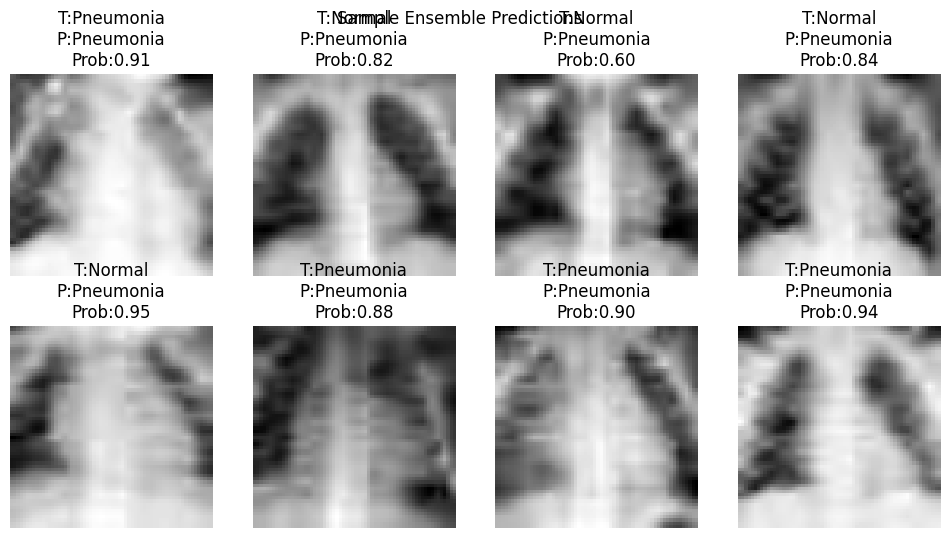

In [ ]:
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(imgs_all[i].squeeze(), cmap='gray')
    true_lbl = LABELS[y_all[i]]
    pred_lbl = LABELS[ensemble_preds[i]]
    plt.title(f"T:{true_lbl}\nP:{pred_lbl}\nProb:{ensemble_probs[i]:.2f}")
    plt.axis('off')
plt.suptitle('Sample Ensemble Predictions'); plt.show()

In [ ]:
os.makedirs("outputs", exist_ok=True)
for name, model in models.items():
    fname = f"outputs/{name}.weights.h5"
    model.save_weights(fname)
print("Saved weights to ./outputs/")

Saved weights to ./outputs/


In [ ]:
print("\nSUMMARY of accuracies:")
for name, acc in accs.items():
    print(f"  {name}: {acc:.4f}")
print(f"  Ensemble: {ensemble_acc:.4f}, Ensemble AUC: {roc_auc:.4f}")


SUMMARY of accuracies:
  SimpleCNN: 0.8365
  ResNetLike: 0.8654
  DenseNetLike: 0.6250
  VGGLike: 0.8478
  InceptionLike: 0.6250
  Ensemble: 0.8349, Ensemble AUC: 0.9199


In [ ]:
import os, random, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, brier_score_loss
)
from sklearn.calibration import calibration_curve
import pandas as pd

In [ ]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "pneumonia_mnist",
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
)
LABELS = ds_info.features['label'].names
IMG_SIZE = (64, 64)
BATCH = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    image = tf.reshape(image, [IMG_SIZE[0], IMG_SIZE[1], 1])
    return image, label

train_ds = ds_train.map(preprocess).shuffle(512, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)


imgs_all, y_all = [], []
for x, y in test_ds:
    imgs_all.append(x.numpy()); y_all.append(y.numpy())
imgs_all = np.concatenate(imgs_all, axis=0)
y_all    = np.concatenate(y_all, axis=0)
N = len(y_all)
print("Test size:", N, "| Labels:", LABELS)

Test size: 624 | Labels: ['Normal', 'Pneumonia']


In [ ]:
def build_simple_cnn():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def resnet_block(x, f=32):
    y = tf.keras.layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    y = tf.keras.layers.Conv2D(f, 3, padding='same')(y)
    y = tf.keras.layers.Add()([x, y])
    return tf.keras.layers.Activation('relu')(y)

def build_resnet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = resnet_block(x, 32)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def dense_block(x, f=16):
    y = tf.keras.layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    return tf.keras.layers.Concatenate()([x, y])

def build_densenet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(inp)
    x = dense_block(x, 16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = dense_block(x, 32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_vgg_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def inception_module(x, f=16):
    p1 = tf.keras.layers.Conv2D(f, 1, padding='same', activation='relu')(x)
    p2 = tf.keras.layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    p3 = tf.keras.layers.Conv2D(f, 5, padding='same', activation='relu')(x)
    p4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
    p4 = tf.keras.layers.Conv2D(f, 1, padding='same', activation='relu')(p4)
    return tf.keras.layers.Concatenate()([p1, p2, p3, p4])

def build_inception_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(inp)
    x = inception_module(x, 16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = inception_module(x, 32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m


In [ ]:
models = {
    "CNN": build_simple_cnn(),
    "ResNet": build_resnet_like(),
    "DenseNet": build_densenet_like(),
    "VGG": build_vgg_like(),
    "Inception": build_inception_like(),
}

EPOCHS = 2
histories = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    histories[name] = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose=1)


Training CNN...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.8203 - loss: 0.4162 - val_accuracy: 0.8574 - val_loss: 0.4538
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.9284 - loss: 0.1717 - val_accuracy: 0.8381 - val_loss: 0.6056

Training ResNet...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.7677 - loss: 0.4765 - val_accuracy: 0.8558 - val_loss: 0.4369
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.9183 - loss: 0.1953 - val_accuracy: 0.8429 - val_loss: 0.5655

Training DenseNet...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.7462 - loss: 0.5893 - val_accuracy: 0.6250 - val_loss: 0.7021
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - accuracy: 0.7406 - loss: 0.5771 - val_accuracy: 0.6250 - val_loss: 0.7248

Training VGG...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 93s 618ms/step - accuracy: 0.7943 - loss: 0.4565 - val_accuracy: 0.8574 - val_loss: 0.3964
Epoch 2/2
148/

In [ ]:
probs_dict, accs = {}, {}
for name, model in models.items():
    probs = model.predict(imgs_all, batch_size=64, verbose=0).ravel()
    probs_dict[name] = probs
    preds = (probs >= 0.5).astype(int)
    accs[name] = accuracy_score(y_all, preds)
    print(f"{name} accuracy (thr=0.5): {accs[name]:.4f}")


ensemble_probs = np.mean(np.stack(list(probs_dict.values()), axis=0), axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)
ensemble_acc = accuracy_score(y_all, ensemble_preds)
print(f"\nEnsemble accuracy (thr=0.5): {ensemble_acc:.4f}")

CNN accuracy (thr=0.5): 0.8381
ResNet accuracy (thr=0.5): 0.8429
DenseNet accuracy (thr=0.5): 0.6250
VGG accuracy (thr=0.5): 0.8510
Inception accuracy (thr=0.5): 0.6250

Ensemble accuracy (thr=0.5): 0.8205


In [ ]:
out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

rows = []
for name in models.keys():
    p = probs_dict[name]
    preds = (p >= 0.5).astype(int)
    cm  = confusion_matrix(y_all, preds)

    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_all, preds),
        "tn": cm[0,0], "fp": cm[0,1], "fn": cm[1,0], "tp": cm[1,1],
    })


cm_ens = confusion_matrix(y_all, ensemble_preds)
rows.append({
    "model": "Ensemble",
    "accuracy": ensemble_acc,
    "tn": cm_ens[0,0], "fp": cm_ens[0,1], "fn": cm_ens[1,0], "tp": cm_ens[1,1],
})

df_metrics = pd.DataFrame(rows)
print("\n=== OUTPUT 1: Metrics Table ===")
print(df_metrics.to_string(index=False))
csv_path = os.path.join(out_dir, "metrics_table.csv")
df_metrics.to_csv(csv_path, index=False)
print("Saved:", csv_path)


=== OUTPUT 1: Metrics Table ===
    model  accuracy  tn  fp  fn  tp
      CNN  0.838141 141  93   8 382
   ResNet  0.842949 154  80  18 372
 DenseNet  0.625000   0 234   0 390
      VGG  0.850962 149  85   8 382
Inception  0.625000   0 234   0 390
 Ensemble  0.820513 125 109   3 387
Saved: outputs/metrics_table.csv



=== OUTPUT 2: ROC AUC (Ensemble) = 0.9085


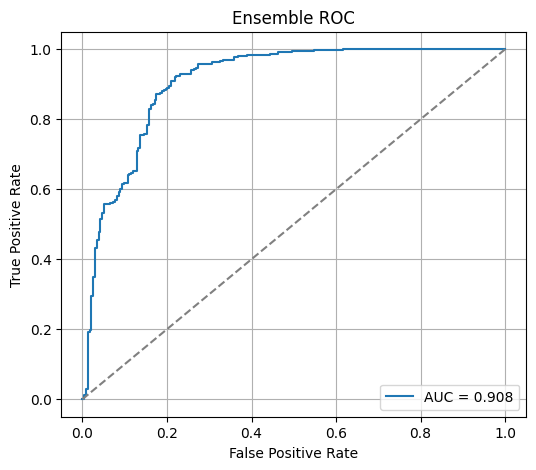

In [ ]:
fpr, tpr, _ = roc_curve(y_all, ensemble_probs)
roc_auc = auc(fpr, tpr)
print(f"\n=== OUTPUT 2: ROC AUC (Ensemble) = {roc_auc:.4f}")

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC")
plt.legend(); plt.grid(True)
plt.show()



=== OUTPUT 3: PR AUC (Ensemble) = 0.9111


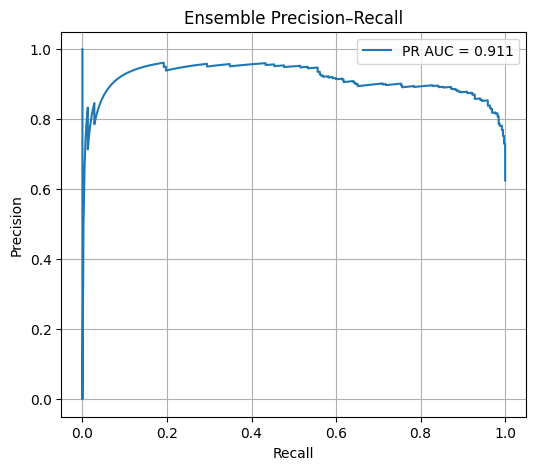

In [ ]:
prec, rec, _ = precision_recall_curve(y_all, ensemble_probs)
pr_auc = auc(rec, prec)
print(f"\n=== OUTPUT 3: PR AUC (Ensemble) = {pr_auc:.4f}")

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Ensemble Precision–Recall")
plt.legend(); plt.grid(True)
plt.show()


=== OUTPUT 4: Brier score (Ensemble) = 0.1409 (lower is better)


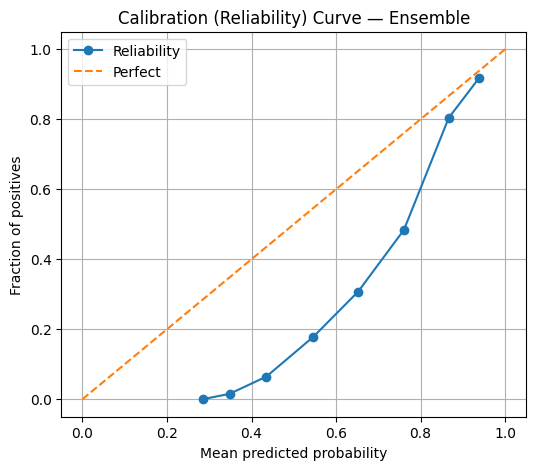

In [ ]:
prob_true, prob_pred = calibration_curve(y_all, ensemble_probs, n_bins=10)
brier = brier_score_loss(y_all, ensemble_probs)
print(f"\n=== OUTPUT 4: Brier score (Ensemble) = {brier:.4f} (lower is better)")

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Reliability')
plt.plot([0,1],[0,1],'--', label='Perfect')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration (Reliability) Curve — Ensemble")
plt.legend(); plt.grid(True)
plt.show()


=== OUTPUT 5: False Negatives — total 3 ===


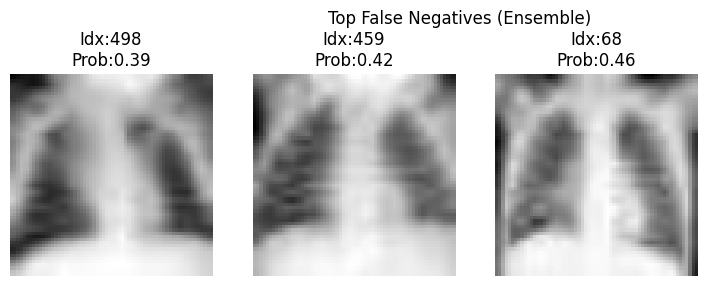

Saved FN PNGs to: outputs/false_negatives


In [ ]:
fn_idx = np.where((y_all == 1) & (ensemble_preds == 0))[0]
print(f"\n=== OUTPUT 5: False Negatives — total {len(fn_idx)} ===")


if len(fn_idx) > 0:
    order = np.argsort(ensemble_probs[fn_idx])
    top_k = fn_idx[order][:8]

    err_dir = os.path.join(out_dir, "false_negatives")
    os.makedirs(err_dir, exist_ok=True)

    plt.figure(figsize=(12,6))
    for i, idx in enumerate(top_k):
        plt.subplot(2,4,i+1)
        plt.imshow(imgs_all[idx].squeeze(), cmap='gray')
        plt.title(f"Idx:{idx}\nProb:{ensemble_probs[idx]:.2f}")
        plt.axis('off')

        fname = os.path.join(err_dir, f"FN_idx{idx}_prob{ensemble_probs[idx]:.3f}.png")
        plt.imsave(fname, imgs_all[idx].squeeze(), cmap='gray')
    plt.suptitle("Top False Negatives (Ensemble)")
    plt.show()
    print("Saved FN PNGs to:", err_dir)
else:
    print("No false negatives to display/save.")

In [ ]:
for name, model in models.items():
    model.save_weights(os.path.join(out_dir, f"{name}.weights.h5"))
print("Saved weights to:", out_dir)


Saved weights to: outputs


In [ ]:
print("\nSUMMARY:")
print(df_metrics.to_string(index=False))
print(f"Ensemble ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f} | Brier: {brier:.4f}")


SUMMARY:
    model  accuracy  tn  fp  fn  tp
      CNN  0.838141 141  93   8 382
   ResNet  0.842949 154  80  18 372
 DenseNet  0.625000   0 234   0 390
      VGG  0.850962 149  85   8 382
Inception  0.625000   0 234   0 390
 Ensemble  0.820513 125 109   3 387
Ensemble ROC AUC: 0.9085 | PR AUC: 0.9111 | Brier: 0.1409


In [ ]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.manifold import TSNE


In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

OUT = "outputs_diff"
os.makedirs(OUT, exist_ok=True)

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "pneumonia_mnist",
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
)
LABELS = ds_info.features["label"].names
IMG_SIZE = (64,64)
BATCH = 32

def preprocess(img, lbl):
    img = tf.image.resize(img, IMG_SIZE) / 255.0
    img = tf.reshape(img, [IMG_SIZE[0], IMG_SIZE[1], 1])
    return img, lbl

train_ds = ds_train.map(preprocess).shuffle(512, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)


imgs_all_list, y_all_list = [], []
for imgs, labs in test_ds:
    imgs_all_list.append(imgs.numpy())
    y_all_list.append(labs.numpy())
imgs_all = np.concatenate(imgs_all_list, axis=0)
y_all = np.concatenate(y_all_list, axis=0)
N = len(y_all)
print("Test size:", N, "| Labels:", LABELS)

Test size: 624 | Labels: ['Normal', 'Pneumonia']


In [ ]:
def build_simple_cnn(name="SimpleCNN"):
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128,3,activation='relu',padding='same', name='last_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp, out, name=name)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def resnet_block(x, filters):
    y = tf.keras.layers.Conv2D(filters,3, padding='same', activation='relu')(x)
    y = tf.keras.layers.Conv2D(filters,3, padding='same')(y)
    out = tf.keras.layers.Add()([x, y])
    return tf.keras.layers.Activation('relu')(out)

def build_resnet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = resnet_block(x,32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64,activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp, out, name='ResNetLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def dense_block(x, filters):
    y = tf.keras.layers.Conv2D(filters,3, padding='same', activation='relu')(x)
    return tf.keras.layers.Concatenate()([x, y])

def build_densenet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inp)
    x = dense_block(x,16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = dense_block(x,32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out, name='DenseNetLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_vgg_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same', name='last_conv_vgg')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out, name='VGGLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def inception_module(x, f=16):
    p1 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(x)
    p2 = tf.keras.layers.Conv2D(f,3,activation='relu',padding='same')(x)
    p3 = tf.keras.layers.Conv2D(f,5,activation='relu',padding='same')(x)
    p4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
    p4 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(p4)
    return tf.keras.layers.Concatenate()([p1,p2,p3,p4])

def build_inception_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inp)
    x = inception_module(x, 16)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out,name='InceptionLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m


models = {
    "SimpleCNN": build_simple_cnn(),
    "ResNet": build_resnet_like(),
    "DenseNet": build_densenet_like(),
    "VGG": build_vgg_like(),
    "Inception": build_inception_like()
}

In [ ]:
EPOCHS = 2
histories = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    histories[name] = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose=1)


Training SimpleCNN ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 263ms/step - accuracy: 0.7189 - loss: 0.5954 - val_accuracy: 0.6250 - val_loss: 0.7300
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - accuracy: 0.7425 - loss: 0.5607 - val_accuracy: 0.6875 - val_loss: 0.6465

Training ResNet ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.6863 - loss: 0.6104 - val_accuracy: 0.6250 - val_loss: 0.6790
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.7358 - loss: 0.5590 - val_accuracy: 0.6971 - val_loss: 0.5668

Training DenseNet ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.7430 - loss: 0.5841 - val_accuracy: 0.6250 - val_loss: 0.6733
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.7374 - loss: 0.5678 - val_accuracy: 0.6330 - val_loss: 0.6558

Training VGG ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 89s 587ms/step - accuracy: 0.7214 - loss: 0.5918 - val_accuracy: 0.6250 - val_loss: 0.6945
Epoc

In [ ]:
probs = {}
aucs = {}
accs = {}
for name, model in models.items():
    p = model.predict(imgs_all, batch_size=64, verbose=0).ravel()
    probs[name] = p
    preds = (p >= 0.5).astype(int)
    accs[name] = accuracy_score(y_all, preds)
    cm = confusion_matrix(y_all, preds)

    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(f"{name} Confusion Matrix")
    plt.xticks([0,1], LABELS, rotation=45); plt.yticks([0,1], LABELS)
    th = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i,j]), ha='center', color='white' if cm[i,j] > th else 'black')
    plt.tight_layout()
    cm_path = os.path.join(OUT, f"{name}_confusion.png")
    plt.savefig(cm_path)
    plt.close()

    fpr, tpr, _ = roc_curve(y_all, p)
    aucs[name] = auc(fpr, tpr)
    print(f"{name}: acc={accs[name]:.4f}, AUC={aucs[name]:.4f} (confusion saved -> {cm_path})")

SimpleCNN: acc=0.6875, AUC=0.6976 (confusion saved -> outputs_diff/SimpleCNN_confusion.png)
ResNet: acc=0.6971, AUC=0.7885 (confusion saved -> outputs_diff/ResNet_confusion.png)
DenseNet: acc=0.6330, AUC=0.6949 (confusion saved -> outputs_diff/DenseNet_confusion.png)
VGG: acc=0.6859, AUC=0.7389 (confusion saved -> outputs_diff/VGG_confusion.png)
Inception: acc=0.6250, AUC=0.6431 (confusion saved -> outputs_diff/Inception_confusion.png)


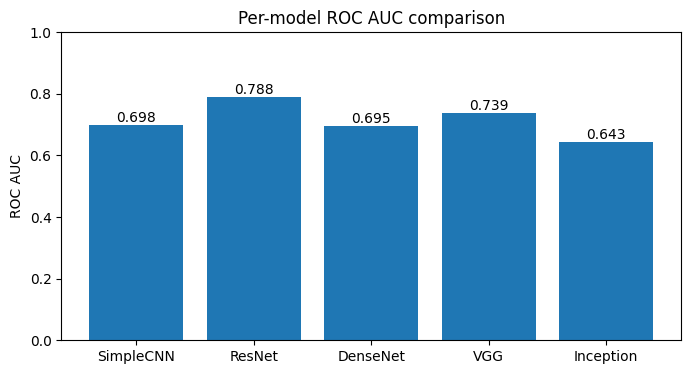

Saved AUC bar chart -> outputs_diff/per_model_auc.png


In [ ]:
names = list(aucs.keys())
vals = [aucs[n] for n in names]
plt.figure(figsize=(8,4))
bars = plt.bar(names, vals)
plt.ylim(0.0, 1.0)
plt.ylabel("ROC AUC")
plt.title("Per-model ROC AUC comparison")
for bar, v in zip(bars, vals):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.01, f"{v:.3f}", ha='center')
auc_path = os.path.join(OUT, "per_model_auc.png")
plt.savefig(auc_path); plt.show()
print("Saved AUC bar chart ->", auc_path)

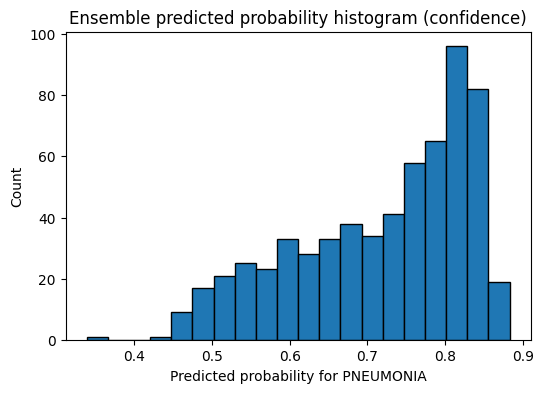

Saved ensemble confidence histogram -> outputs_diff/ensemble_confidence_hist.png


In [ ]:
ensemble_probs = np.mean(np.stack(list(probs.values()), axis=0), axis=0)
plt.figure(figsize=(6,4))
plt.hist(ensemble_probs, bins=20, edgecolor='k')
plt.title("Ensemble predicted probability histogram (confidence)")
plt.xlabel("Predicted probability for PNEUMONIA")
plt.ylabel("Count")
hist_path = os.path.join(OUT, "ensemble_confidence_hist.png")
plt.savefig(hist_path); plt.show()
print("Saved ensemble confidence histogram ->", hist_path)

In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

def make_gradcam(model, img, last_conv_name=None):

    img_batch = np.expand_dims(img, axis=0).astype(np.float32)
    if last_conv_name is None:
        last_conv_name = find_last_conv_layer(model)
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_batch)
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[..., i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], IMG_SIZE).numpy().squeeze()
    return heatmap_resized


cam_model = models["SimpleCNN"]
last_conv = find_last_conv_layer(cam_model)
print("Using last conv layer for Grad-CAM:", last_conv)


ens_preds = (ensemble_probs >= 0.5).astype(int)
tp_idx = np.where((y_all == 1) & (ens_preds == 1))[0]
fn_idx = np.where((y_all == 1) & (ens_preds == 0))[0]

selected = []
if len(tp_idx) >= 2:
    selected.extend(tp_idx[:2])
if len(fn_idx) >= 2:
    selected.extend(fn_idx[:2])

if len(selected) < 4:
    selected = list(np.random.choice(np.arange(N), size=4, replace=False))

print("Grad-CAM selected indices:", selected)

gradcam_dir = os.path.join(OUT, "gradcam")
os.makedirs(gradcam_dir, exist_ok=True)
for idx in selected:
    img = imgs_all[idx].squeeze()
    heat = make_gradcam(cam_model, imgs_all[idx], last_conv_name=last_conv)

    cmap = plt.get_cmap("jet")
    heat_col = cmap(heat)[:,:,:3]
    img_rgb = np.repeat(img[..., np.newaxis], 3, axis=-1)
    overlay = 0.5 * img_rgb + 0.5 * heat_col
    overlay = np.clip(overlay, 0, 1)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray'); plt.title(f"Idx {idx} True:{LABELS[y_all[idx]]}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(overlay); plt.title("Grad-CAM overlay")
    plt.axis('off')
    fname = os.path.join(gradcam_dir, f"gradcam_idx{idx}.png")
    plt.savefig(fname); plt.close()
    print("Saved Grad-CAM ->", fname)


Using last conv layer for Grad-CAM: last_conv
Grad-CAM selected indices: [np.int64(0), np.int64(5), np.int64(47), np.int64(562)]
Saved Grad-CAM -> outputs_diff/gradcam/gradcam_idx0.png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_124']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


Saved Grad-CAM -> outputs_diff/gradcam/gradcam_idx5.png
Saved Grad-CAM -> outputs_diff/gradcam/gradcam_idx47.png
Saved Grad-CAM -> outputs_diff/gradcam/gradcam_idx562.png


Running t-SNE on 300 samples ... (this may take a few seconds)


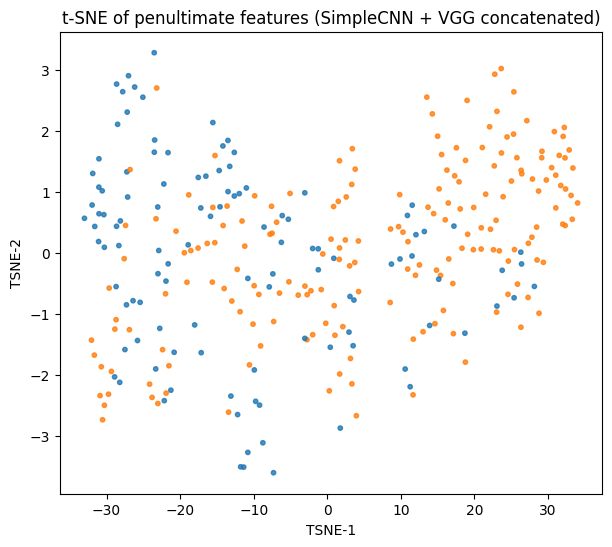

Saved t-SNE plot -> outputs_diff/tsne_penultimate.png


In [ ]:
def extract_penultimate(model, imgs, layer_name='penultimate'):
    inter = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feats = inter.predict(imgs, batch_size=64, verbose=0)
    return feats


max_samples = min(300, N)
sel_idx = np.random.choice(np.arange(N), size=max_samples, replace=False)
sel_imgs = imgs_all[sel_idx]
sel_labels = y_all[sel_idx]

feats_simple = extract_penultimate(models["SimpleCNN"], sel_imgs)
feats_vgg = extract_penultimate(models["VGG"], sel_imgs)

feats_concat = np.concatenate([feats_simple, feats_vgg], axis=1)

print("Running t-SNE on", feats_concat.shape[0], "samples ... (this may take a few seconds)")
tsne = TSNE(n_components=2, random_state=SEED, init='pca', learning_rate='auto', perplexity=30)
feat2d = tsne.fit_transform(feats_concat)

plt.figure(figsize=(7,6))
colors = ['tab:blue' if l==0 else 'tab:orange' for l in sel_labels]
plt.scatter(feat2d[:,0], feat2d[:,1], c=colors, s=10, alpha=0.8)
plt.title("t-SNE of penultimate features (SimpleCNN + VGG concatenated)")
plt.xlabel("TSNE-1"); plt.ylabel("TSNE-2")
tsne_path = os.path.join(OUT, "tsne_penultimate.png")
plt.savefig(tsne_path); plt.show()
print("Saved t-SNE plot ->", tsne_path)

In [ ]:
for name, model in models.items():
    model.save_weights(os.path.join(OUT, f"{name}.weights.h5"))

print("\nAll outputs saved under directory:", OUT)
print("Per-model confusion PNGs, AUC bar chart, ensemble histogram, Grad-CAM PNGs, t-SNE PNG.")


All outputs saved under directory: outputs_diff
Per-model confusion PNGs, AUC bar chart, ensemble histogram, Grad-CAM PNGs, t-SNE PNG.


In [ ]:
import os, random, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

OUTDIR = "outputs_more"
os.makedirs(OUTDIR, exist_ok=True)

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "pneumonia_mnist",
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
)
LABELS = ds_info.features['label'].names  # ['NORMAL','PNEUMONIA']
print("Labels:", LABELS)

IMG_SIZE = (64,64)
BATCH = 32

def preprocess(img, lbl):
    img = tf.image.resize(img, IMG_SIZE) / 255.0
    img = tf.reshape(img, [IMG_SIZE[0], IMG_SIZE[1], 1])
    return img, lbl

train_ds = ds_train.map(preprocess).shuffle(512, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)


imgs_list, y_list = [], []
for x, y in test_ds:
    imgs_list.append(x.numpy())
    y_list.append(y.numpy())
imgs_all = np.concatenate(imgs_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
N = len(y_all)
print("Test set size:", N)

Labels: ['Normal', 'Pneumonia']
Test set size: 624


In [ ]:
def build_simple_cnn():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def resnet_block(x, f=32):
    y = tf.keras.layers.Conv2D(f,3,padding='same',activation='relu')(x)
    y = tf.keras.layers.Conv2D(f,3,padding='same')(y)
    y = tf.keras.layers.Add()([x,y])
    return tf.keras.layers.Activation('relu')(y)

def build_resnet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = resnet_block(x,32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def dense_block(x, f=16):
    y = tf.keras.layers.Conv2D(f,3,padding='same',activation='relu')(x)
    return tf.keras.layers.Concatenate()([x,y])

def build_densenet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inp)
    x = dense_block(x,16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = dense_block(x,32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_vgg_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def inception_module(x, f=16):
    p1 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(x)
    p2 = tf.keras.layers.Conv2D(f,3,activation='relu',padding='same')(x)
    p3 = tf.keras.layers.Conv2D(f,5,activation='relu',padding='same')(x)
    p4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
    p4 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(p4)
    return tf.keras.layers.Concatenate()([p1,p2,p3,p4])

def build_inception_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inp)
    x = inception_module(x,16)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    out = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

In [ ]:
models = {
    "CNN": build_simple_cnn(),
    "ResNet": build_resnet_like(),
    "DenseNet": build_densenet_like(),
    "VGG": build_vgg_like(),
    "Inception": build_inception_like()
}


In [ ]:
EPOCHS = 2
histories = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    histories[name] = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose=1)


Training CNN ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.7814 - loss: 0.4687 - val_accuracy: 0.8574 - val_loss: 0.3682
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - accuracy: 0.9225 - loss: 0.1972 - val_accuracy: 0.8237 - val_loss: 0.6560

Training ResNet ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.7338 - loss: 0.5934 - val_accuracy: 0.6250 - val_loss: 0.6793
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.7355 - loss: 0.5667 - val_accuracy: 0.6266 - val_loss: 0.6783

Training DenseNet ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.7387 - loss: 0.5904 - val_accuracy: 0.6250 - val_loss: 0.6672
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.7374 - loss: 0.5724 - val_accuracy: 0.6266 - val_loss: 0.7160

Training VGG ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 94s 615ms/step - accuracy: 0.8023 - loss: 0.4428 - val_accuracy: 0.8510 - val_loss: 0.4132
Epoch 2/2


In [ ]:
probs_dict = {}
metrics_rows = []
for name, model in models.items():
    probs = model.predict(imgs_all, batch_size=64, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    probs_dict[name] = probs
    acc = accuracy_score(y_all, preds)
    prec = precision_score(y_all, preds, zero_division=0)
    rec = recall_score(y_all, preds, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_all, preds).ravel()
    metrics_rows.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "params": int(model.count_params())
    })
    print(f"{name}: acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, params={model.count_params()}")


ensemble_probs = np.mean(np.stack(list(probs_dict.values()), axis=0), axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)
ensemble_acc = accuracy_score(y_all, ensemble_preds)
ensemble_prec = precision_score(y_all, ensemble_preds, zero_division=0)
ensemble_rec = recall_score(y_all, ensemble_preds, zero_division=0)

metrics_rows.append({
    "model": "Ensemble",
    "accuracy": ensemble_acc,
    "precision": ensemble_prec,
    "recall": ensemble_rec,
    "tn": int(confusion_matrix(y_all, ensemble_preds).ravel()[0]),
    "fp": int(confusion_matrix(y_all, ensemble_preds).ravel()[1]),
    "fn": int(confusion_matrix(y_all, ensemble_preds).ravel()[2]),
    "tp": int(confusion_matrix(y_all, ensemble_preds).ravel()[3]),
    "params": sum([int(m.count_params()) for m in models.values()])
})


df_summary = pd.DataFrame(metrics_rows)
summary_path = os.path.join(OUTDIR, "model_summary.csv")
df_summary.to_csv(summary_path, index=False)
print("\n=== OUTPUT 5: Model summary saved ->", summary_path)
print(df_summary.to_string(index=False))


CNN: acc=0.8237, prec=0.7881, rec=0.9821, params=2116225
ResNet: acc=0.6266, prec=0.6264, rec=0.9974, params=20993
DenseNet: acc=0.6266, prec=0.6260, rec=1.0000, params=15953
VGG: acc=0.8558, prec=0.8261, rec=0.9744, params=2162401
Inception: acc=0.6250, prec=0.6250, rec=1.0000, params=13665

=== OUTPUT 5: Model summary saved -> outputs_more/model_summary.csv
    model  accuracy  precision   recall  tn  fp  fn  tp  params
      CNN  0.823718   0.788066 0.982051 131 103   7 383 2116225
   ResNet  0.626603   0.626409 0.997436   2 232   1 389   20993
 DenseNet  0.626603   0.626003 1.000000   1 233   0 390   15953
      VGG  0.855769   0.826087 0.974359 154  80  10 380 2162401
Inception  0.625000   0.625000 1.000000   0 234   0 390   13665
 Ensemble  0.775641   0.735849 1.000000  94 140   0 390 4329237


In [ ]:
for name, hist in histories.items():
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train loss')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='val loss')
    plt.title(f"{name} Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history.get('accuracy', []), label='train acc')
    if 'val_accuracy' in hist.history:
        plt.plot(hist.history['val_accuracy'], label='val acc')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    fname = os.path.join(OUTDIR, f"{name}_learning_curves.png")
    plt.tight_layout(); plt.savefig(fname); plt.close()
    print("Saved learning curves ->", fname)


Saved learning curves -> outputs_more/CNN_learning_curves.png
Saved learning curves -> outputs_more/ResNet_learning_curves.png
Saved learning curves -> outputs_more/DenseNet_learning_curves.png
Saved learning curves -> outputs_more/VGG_learning_curves.png
Saved learning curves -> outputs_more/Inception_learning_curves.png


In [ ]:
models_list = [r['model'] for r in metrics_rows]
prec_vals = [r['precision'] for r in metrics_rows]
rec_vals  = [r['recall'] for r in metrics_rows]

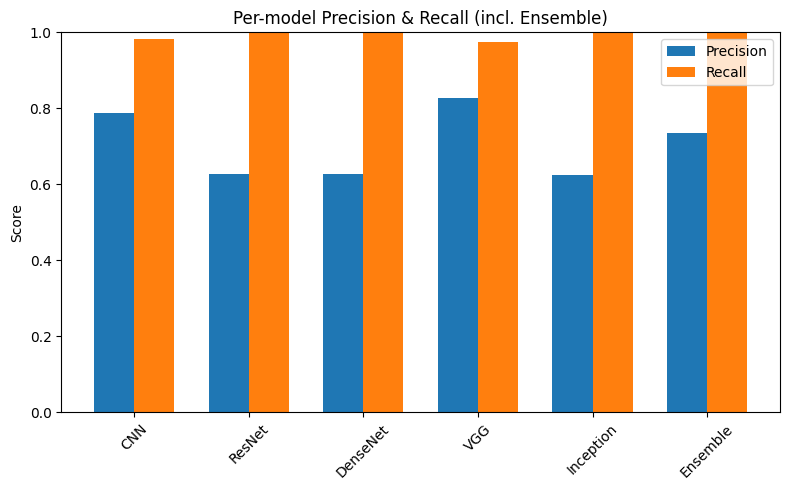

=== OUTPUT 2: Saved precision/recall bar chart -> outputs_more/precision_recall_bar.png


In [ ]:
plt.figure(figsize=(8,5))
x = np.arange(len(models_list))
width = 0.35
plt.bar(x - width/2, prec_vals, width, label='Precision')
plt.bar(x + width/2, rec_vals, width, label='Recall')
plt.xticks(x, models_list, rotation=45)
plt.ylabel("Score"); plt.ylim(0,1)
plt.title("Per-model Precision & Recall (incl. Ensemble)")
plt.legend()
precrec_path = os.path.join(OUTDIR, "precision_recall_bar.png")
plt.tight_layout(); plt.savefig(precrec_path); plt.show()
print("=== OUTPUT 2: Saved precision/recall bar chart ->", precrec_path)

In [ ]:
df_preds = pd.DataFrame({
    "true_label": y_all
})
for name, probs in probs_dict.items():
    df_preds[f"prob_{name}"] = probs
df_preds["prob_ensemble"] = ensemble_probs
df_preds["pred_ensemble"] = ensemble_preds
preds_csv = os.path.join(OUTDIR, "per_sample_predictions.csv")
df_preds.to_csv(preds_csv, index=False)
print("=== OUTPUT 3: Saved per-sample predictions CSV ->", preds_csv)

=== OUTPUT 3: Saved per-sample predictions CSV -> outputs_more/per_sample_predictions.csv


In [ ]:
tp_idx = np.where((y_all == 1) & (ensemble_preds == 1))[0]
print("Total true positives (ensemble):", len(tp_idx))
if len(tp_idx) > 0:
    sorted_tp = tp_idx[np.argsort(-ensemble_probs[tp_idx])]
    topk = sorted_tp[:12]
    gallery_dir = os.path.join(OUTDIR, "top_true_positives")
    os.makedirs(gallery_dir, exist_ok=True)
    plt.figure(figsize=(12,8))
    for i, idx in enumerate(topk):
        plt.subplot(3,4,i+1)
        plt.imshow(imgs_all[idx].squeeze(), cmap='gray')
        plt.title(f"Idx:{idx}\nProb:{ensemble_probs[idx]:.2f}")
        plt.axis('off')

        plt.imsave(os.path.join(gallery_dir, f"TP_idx{idx}_prob{ensemble_probs[idx]:.3f}.png"), imgs_all[idx].squeeze(), cmap='gray')
    plt.suptitle("Top True Positives (ensemble confidence desc.)")
    gallery_path = os.path.join(OUTDIR, "top_true_positives_grid.png")
    plt.tight_layout(); plt.savefig(gallery_path); plt.close()
    print("=== OUTPUT 4: Saved top true positives grid ->", gallery_path)
    print("saved individual TP PNGs ->", gallery_dir)
else:
    print("No true positives found to show.")

Total true positives (ensemble): 390
=== OUTPUT 4: Saved top true positives grid -> outputs_more/top_true_positives_grid.png
saved individual TP PNGs -> outputs_more/top_true_positives


In [ ]:
for name, model in models.items():
    model.save_weights(os.path.join(OUTDIR, f"{name}.weights.h5"))
print("Saved model weights (use .weights.h5) to", OUTDIR)

Saved model weights (use .weights.h5) to outputs_more


In [ ]:
print("\nAll outputs saved under:", OUTDIR)
print("Files:")
for root, dirs, files in os.walk(OUTDIR):
    for f in files:
        print(" -", os.path.join(root, f))


All outputs saved under: outputs_more
Files:
 - outputs_more/Inception_learning_curves.png
 - outputs_more/ResNet.weights.h5
 - outputs_more/top_true_positives_grid.png
 - outputs_more/VGG.weights.h5
 - outputs_more/VGG_learning_curves.png
 - outputs_more/DenseNet.weights.h5
 - outputs_more/DenseNet_learning_curves.png
 - outputs_more/CNN.weights.h5
 - outputs_more/ResNet_learning_curves.png
 - outputs_more/CNN_learning_curves.png
 - outputs_more/model_summary.csv
 - outputs_more/precision_recall_bar.png
 - outputs_more/Inception.weights.h5
 - outputs_more/per_sample_predictions.csv
 - outputs_more/top_true_positives/TP_idx614_prob0.907.png
 - outputs_more/top_true_positives/TP_idx593_prob0.908.png
 - outputs_more/top_true_positives/TP_idx564_prob0.903.png
 - outputs_more/top_true_positives/TP_idx385_prob0.901.png
 - outputs_more/top_true_positives/TP_idx430_prob0.903.png
 - outputs_more/top_true_positives/TP_idx618_prob0.914.png
 - outputs_more/top_true_positives/TP_idx45_prob0.903.p

In [ ]:
import os, random, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import (
    precision_recall_curve, auc, accuracy_score, confusion_matrix,
    matthews_corrcoef, balanced_accuracy_score, brier_score_loss
)
from sklearn.model_selection import train_test_split


In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

OUT = "outputs_more_diff"
os.makedirs(OUT, exist_ok=True)

In [ ]:
(ds_train_full, ds_test), ds_info = tfds.load(
    "pneumonia_mnist",
    split=["train", "test"],
    as_supervised=True,
    with_info=True,
)
LABELS = ds_info.features['label'].names
IMG_SIZE = (64, 64)
BATCH = 32

def preprocess(img, lbl):
    img = tf.image.resize(img, IMG_SIZE) / 255.0
    img = tf.reshape(img, [IMG_SIZE[0], IMG_SIZE[1], 1])
    return img, lbl


train_imgs_list, train_lbls_list = [], []
for x, y in ds_train_full.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE):
    train_imgs_list.append(x.numpy()); train_lbls_list.append(y.numpy())
train_imgs_all = np.concatenate(train_imgs_list, axis=0)
train_lbls_all = np.concatenate(train_lbls_list, axis=0)


train_X, val_X, train_y, val_y = train_test_split(
    train_imgs_all, train_lbls_all, test_size=0.1, random_state=SEED, stratify=train_lbls_all
)


train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y)).shuffle(512, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y)).batch(BATCH).prefetch(tf.data.AUTOTUNE)


test_ds_tf = ds_test.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)
imgs_all, y_all = [], []
for x,y in test_ds_tf:
    imgs_all.append(x.numpy()); y_all.append(y.numpy())
imgs_all = np.concatenate(imgs_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
N = len(y_all)
print("Train size (approx):", len(train_X), "Val size:", len(val_X), "Test size:", N)


Train size (approx): 4237 Val size: 471 Test size: 624


In [ ]:
def build_simple_cnn():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def resnet_block(x, filters=32):
    y = tf.keras.layers.Conv2D(filters,3, padding='same', activation='relu')(x)
    y = tf.keras.layers.Conv2D(filters,3, padding='same')(y)
    out = tf.keras.layers.Add()([x, y])
    return tf.keras.layers.Activation('relu')(out)

def build_resnet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = resnet_block(x,32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def dense_block(x, f=16):
    y = tf.keras.layers.Conv2D(f,3, padding='same', activation='relu')(x)
    return tf.keras.layers.Concatenate()([x,y])

def build_densenet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16,3, activation='relu', padding='same')(inp)
    x = dense_block(x,16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = dense_block(x,32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp, out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_vgg_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def inception_module(x, f=16):
    p1 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(x)
    p2 = tf.keras.layers.Conv2D(f,3,activation='relu',padding='same')(x)
    p3 = tf.keras.layers.Conv2D(f,5,activation='relu',padding='same')(x)
    p4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
    p4 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(p4)
    return tf.keras.layers.Concatenate()([p1,p2,p3,p4])

def build_inception_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
    x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inp)
    x = inception_module(x,16)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    m = tf.keras.Model(inp,out)
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

models = {
    "CNN": build_simple_cnn(),
    "ResNet": build_resnet_like(),
    "DenseNet": build_densenet_like(),
    "VGG": build_vgg_like(),
    "Inception": build_inception_like()
}


In [ ]:
EPOCHS = 2
histories = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    histories[name] = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)


Training CNN ...
Epoch 1/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.7471 - loss: 0.5851 - val_accuracy: 0.7431 - val_loss: 0.5615
Epoch 2/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.7478 - loss: 0.5572 - val_accuracy: 0.7431 - val_loss: 0.5431

Training ResNet ...
Epoch 1/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.7485 - loss: 0.5718 - val_accuracy: 0.7431 - val_loss: 0.5559
Epoch 2/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.7508 - loss: 0.5452 - val_accuracy: 0.7452 - val_loss: 0.4926

Training DenseNet ...
Epoch 1/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 236ms/step - accuracy: 0.6786 - loss: 0.6076 - val_accuracy: 0.7431 - val_loss: 0.5606
Epoch 2/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 40s 231ms/step - accuracy: 0.7481 - loss: 0.5531 - val_accuracy: 0.7410 - val_loss: 0.5439

Training VGG ...
Epoch 1/2
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 297ms/step - accuracy: 0.7417 - loss: 0.5884 - val_accuracy: 0.7431 - val_loss: 0.5586
Epoch 2/2


In [ ]:
metrics_list = []
probs_dict = {}
for name, model in models.items():
    p = model.predict(imgs_all, batch_size=64, verbose=0).ravel()
    probs_dict[name] = p
    preds = (p >= 0.5).astype(int)
    mcc = matthews_corrcoef(y_all, preds)
    bal = balanced_accuracy_score(y_all, preds)
    fpr, tpr, _ = precision_recall_curve(y_all, p)  # we will compute PR AUC below
    prec, rec, _ = precision_recall_curve(y_all, p)
    pr_auc = auc(rec, prec)
    metrics_list.append({
        "model": name,
        "mcc": float(mcc),
        "balanced_accuracy": float(bal),
        "pr_auc": float(pr_auc),
        "accuracy": float(accuracy_score(y_all, preds))
    })

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{name} PR Curve")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT, f"{name}_pr_curve.png"))
    plt.close()
    print(f"{name}: MCC={mcc:.3f}, BalancedAcc={bal:.3f}, PR_AUC={pr_auc:.3f} (PR saved)")

df_metrics = tf.compat.v1.keras.utils.Progbar if False else None  # keep cell-level imports safe
import pandas as pd
df_metrics = pd.DataFrame(metrics_list)
csv_path = os.path.join(OUT, "per_model_mcc_balanced_pr.csv")
df_metrics.to_csv(csv_path, index=False)
print("\n=== OUTPUT 1 saved ->", csv_path)
print(df_metrics.to_string(index=False))


CNN: MCC=0.000, BalancedAcc=0.500, PR_AUC=0.723 (PR saved)
ResNet: MCC=0.102, BalancedAcc=0.526, PR_AUC=0.820 (PR saved)
DenseNet: MCC=-0.020, BalancedAcc=0.498, PR_AUC=0.746 (PR saved)
VGG: MCC=0.015, BalancedAcc=0.501, PR_AUC=0.731 (PR saved)
Inception: MCC=0.000, BalancedAcc=0.500, PR_AUC=0.725 (PR saved)

=== OUTPUT 1 saved -> outputs_more_diff/per_model_mcc_balanced_pr.csv
    model       mcc  balanced_accuracy   pr_auc  accuracy
      CNN  0.000000           0.500000 0.722798  0.625000
   ResNet  0.101873           0.526068 0.819670  0.633013
 DenseNet -0.019644           0.497863 0.746382  0.620192
      VGG  0.014641           0.500855 0.730828  0.625000
Inception  0.000000           0.500000 0.724968  0.625000


In [ ]:
ensemble_probs = np.mean(np.stack(list(probs_dict.values()), axis=0), axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)


def get_model_logits_on_set(model, imgs):

    p = model.predict(imgs, batch_size=64, verbose=0).ravel()

    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p / (1 - p))


val_logits_stack = []
for name, model in models.items():
    val_logits_stack.append(get_model_logits_on_set(model, val_X))
val_logits_stack = np.stack(val_logits_stack, axis=0)
val_ens_logits = val_logits_stack.mean(axis=0)


def nll_T(T, logits, labels):
    scaled = logits / T
    p = 1 / (1 + np.exp(-scaled))

    eps = 1e-12
    return -np.mean(labels * np.log(p + eps) + (1-labels) * np.log(1 - p + eps))

Ts = np.linspace(0.1, 3.0, 60)
nlls = [nll_T(T, val_ens_logits, val_y) for T in Ts]
best_T = Ts[np.argmin(nlls)]
print(f"\nFound temperature T = {best_T:.3f} (grid search)")


test_logits_stack = []
for name, model in models.items():
    test_logits_stack.append(get_model_logits_on_set(model, imgs_all))
test_logits_stack = np.stack(test_logits_stack, axis=0)
test_ens_logits = test_logits_stack.mean(axis=0)

calib_probs = 1 / (1 + np.exp(-(test_ens_logits / best_T)))

brier_before = brier_score_loss(y_all, ensemble_probs)
brier_after = brier_score_loss(y_all, calib_probs)


def expected_calibration_error(probs, labels, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    bin_ids = np.digitize(probs, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        mask = bin_ids == i
        if np.sum(mask) == 0:
            continue
        acc = np.mean(labels[mask])
        conf = np.mean(probs[mask])
        ece += (np.sum(mask)/len(probs)) * abs(acc - conf)
    return ece

ece_before = expected_calibration_error(ensemble_probs, y_all, n_bins=10)
ece_after = expected_calibration_error(calib_probs, y_all, n_bins=10)

print(f"Brier before: {brier_before:.4f}, after: {brier_after:.4f}")
print(f"ECE before: {ece_before:.4f}, after: {ece_after:.4f}")


calib_summary = {
    "best_temperature": float(best_T),
    "brier_before": float(brier_before),
    "brier_after": float(brier_after),
    "ece_before": float(ece_before),
    "ece_after": float(ece_after)
}
with open(os.path.join(OUT, "ensemble_calibration.json"), "w") as f:
    json.dump(calib_summary, f, indent=2)
print("=== OUTPUT 3 saved -> ensemble_calibration.json")


from sklearn.calibration import calibration_curve
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
pt, pp = calibration_curve(y_all, ensemble_probs, n_bins=10)
plt.plot(pp, pt, marker='o'); plt.plot([0,1],[0,1],'--'); plt.title("Reliability (before)")
plt.xlabel("Mean predicted prob"); plt.ylabel("Fraction positives")
plt.subplot(1,2,2)
pt2, pp2 = calibration_curve(y_all, calib_probs, n_bins=10)
plt.plot(pp2, pt2, marker='o'); plt.plot([0,1],[0,1],'--'); plt.title("Reliability (after)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "reliability_before_after.png"))
plt.close()
print("Saved reliability diagram -> reliability_before_after.png")



Found temperature T = 0.936 (grid search)
Brier before: 0.2365, after: 0.2406
ECE before: 0.1265, after: 0.1389
=== OUTPUT 3 saved -> ensemble_calibration.json
Saved reliability diagram -> reliability_before_after.png


In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

def make_gradcam_heatmap(model, img, last_conv_name=None):

    img_batch = np.expand_dims(img, axis=0).astype(np.float32)
    if last_conv_name is None:
        last_conv_name = find_last_conv_layer(model)
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_batch)
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_outputs[0].numpy()
    pooled = pooled_grads.numpy()
    for i in range(pooled.shape[-1]):
        conv_out[..., i] *= pooled[i]
    heatmap = np.mean(conv_out, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    heat_resized = tf.image.resize(heatmap[..., np.newaxis], IMG_SIZE).numpy().squeeze()
    return heat_resized


ens_preds_before = (ensemble_probs >= 0.5).astype(int)
fn_idx = np.where((y_all == 1) & (ens_preds_before == 0))[0]
if len(fn_idx) > 0:
    sample_idx = int(fn_idx[0])
else:

    pos_idx = np.where(y_all == 1)[0]
    sample_idx = int(pos_idx[0]) if len(pos_idx)>0 else 0

sample_img = imgs_all[sample_idx]
print("Grad-CAM sample index chosen:", sample_idx, "true label:", LABELS[y_all[sample_idx]])

gradcam_dir = os.path.join(OUT, "gradcam_all_models")
os.makedirs(gradcam_dir, exist_ok=True)
for name, model in models.items():
    last_conv = find_last_conv_layer(model)
    if last_conv is None:
        print(f"No conv layer found for {name}, skipping Grad-CAM")
        continue
    heat = make_gradcam_heatmap(model, sample_img, last_conv_name=last_conv)
    cmap = plt.get_cmap("jet")
    heat_col = cmap(heat)[:,:,:3]
    img_rgb = np.repeat(sample_img.squeeze()[..., np.newaxis], 3, axis=-1)
    overlay = 0.5*img_rgb + 0.5*heat_col
    overlay = np.clip(overlay, 0, 1)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(sample_img.squeeze(), cmap='gray'); plt.title(f"{name} input"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"{name} Grad-CAM"); plt.axis('off')
    fname = os.path.join(gradcam_dir, f"{name}_gradcam_idx{sample_idx}.png")
    plt.savefig(fname); plt.close()
    print("Saved Grad-CAM for", name, "->", fname)

Grad-CAM sample index chosen: 562 true label: Pneumonia
Saved Grad-CAM for CNN -> outputs_more_diff/gradcam_all_models/CNN_gradcam_idx562.png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_227']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_234']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


Saved Grad-CAM for ResNet -> outputs_more_diff/gradcam_all_models/ResNet_gradcam_idx562.png
Saved Grad-CAM for DenseNet -> outputs_more_diff/gradcam_all_models/DenseNet_gradcam_idx562.png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_243']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_252']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


Saved Grad-CAM for VGG -> outputs_more_diff/gradcam_all_models/VGG_gradcam_idx562.png
Saved Grad-CAM for Inception -> outputs_more_diff/gradcam_all_models/Inception_gradcam_idx562.png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_258']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import roc_curve
ensemble_pr_prec, ensemble_pr_rec, _ = precision_recall_curve(y_all, ensemble_probs)
ensemble_pr_auc = auc(ensemble_pr_rec, ensemble_pr_prec)
ensemble_mcc = matthews_corrcoef(y_all, (ensemble_probs >= 0.5).astype(int))
ensemble_bal = balanced_accuracy_score(y_all, (ensemble_probs >= 0.5).astype(int))
ensemble_brier = brier_score_loss(y_all, ensemble_probs)

summary = {
    "per_model": {m["model"]: {"mcc":m["mcc"], "balanced_accuracy":m["balanced_accuracy"], "pr_auc":m["pr_auc"], "accuracy":m["accuracy"]} for m in metrics_list},
    "ensemble": {
        "pr_auc": float(ensemble_pr_auc),
        "mcc": float(ensemble_mcc),
        "balanced_accuracy": float(ensemble_bal),
        "brier_before": float(brier_before),
        "brier_after": float(brier_after),
        "ece_before": float(ece_before),
        "ece_after": float(ece_after),
        "temperature": float(best_T)
    }
}
with open(os.path.join(OUT, "summary_all_metrics.json"), "w") as f:
    json.dump(summary, f, indent=2)
print("=== OUTPUT 5 saved -> summary_all_metrics.json")

=== OUTPUT 5 saved -> summary_all_metrics.json


In [ ]:
for name, model in models.items():
    model.save_weights(os.path.join(OUT, f"{name}.weights.h5"))
print("Saved model weights to:", OUT)

print("\nAll outputs saved under:", OUT)
print("Files example:", os.listdir(OUT)[:10])

Saved model weights to: outputs_more_diff

All outputs saved under: outputs_more_diff
Files example: ['VGG_pr_curve.png', 'ResNet.weights.h5', 'DenseNet_pr_curve.png', 'reliability_before_after.png', 'VGG.weights.h5', 'gradcam_all_models', 'DenseNet.weights.h5', 'CNN_pr_curve.png', 'CNN.weights.h5', 'Inception_pr_curve.png']


In [ ]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

In [ ]:
(ds_tr, ds_test), ds_info = tfds.load("pneumonia_mnist",
                                      split=["train", "test"],
                                      as_supervised=True,
                                      with_info=True)
LABELS = ds_info.features["label"].names  # ['NORMAL','PNEUMONIA']
IMG_SIZE = (64,64)
BATCH = 32

def preprocess(img, lbl):
    img = tf.image.resize(img, IMG_SIZE) / 255.0
    img = tf.reshape(img, [IMG_SIZE[0], IMG_SIZE[1], 1])
    return img, lbl

train_ds = ds_tr.map(preprocess).shuffle(512, seed=SEED).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds_tf = ds_test.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# collect test arrays
imgs_list, y_list = [], []
for x,y in test_ds_tf:
    imgs_list.append(x.numpy()); y_list.append(y.numpy())
imgs_all = np.concatenate(imgs_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
N = len(y_all)
print("Test set size:", N, "| Labels:", LABELS)

Test set size: 624 | Labels: ['Normal', 'Pneumonia']


In [ ]:
def build_simple_cnn():
    inp = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out, name='SimpleCNN')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def resnet_block(x, filters):
    y = tf.keras.layers.Conv2D(filters,3,padding='same',activation='relu')(x)
    y = tf.keras.layers.Conv2D(filters,3,padding='same')(y)
    out = tf.keras.layers.Add()([x,y])
    return tf.keras.layers.Activation('relu')(out)

def build_resnet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = resnet_block(x, 32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out, name='ResNetLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def dense_block(x, filters):
    y = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return tf.keras.layers.Concatenate()([x, y])

def build_densenet_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],1))
    x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inp)
    x = dense_block(x,16)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = dense_block(x,32)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out, name='DenseNetLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_vgg_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],1))
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out, name='VGGLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

def inception_module(x, f=16):
    p1 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(x)
    p2 = tf.keras.layers.Conv2D(f,3,activation='relu',padding='same')(x)
    p3 = tf.keras.layers.Conv2D(f,5,activation='relu',padding='same')(x)
    p4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
    p4 = tf.keras.layers.Conv2D(f,1,activation='relu',padding='same')(p4)
    return tf.keras.layers.Concatenate()([p1,p2,p3,p4])

def build_inception_like():
    inp = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],1))
    x = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inp)
    x = inception_module(x,16)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    pen = tf.keras.layers.Dense(64, activation='relu', name='penultimate')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(pen)
    m = tf.keras.Model(inp,out, name='InceptionLike')
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

models = {
    "SimpleCNN": build_simple_cnn(),
    "ResNet": build_resnet_like(),
    "DenseNet": build_densenet_like(),
    "VGG": build_vgg_like(),
    "Inception": build_inception_like()
}


In [ ]:
EPOCHS = 2
histories = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    histories[name] = model.fit(train_ds, validation_data=test_ds_tf, epochs=EPOCHS, verbose=1)


Training SimpleCNN ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.7470 - loss: 0.5907 - val_accuracy: 0.6250 - val_loss: 0.7284
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.7427 - loss: 0.5637 - val_accuracy: 0.6250 - val_loss: 0.6688

Training ResNet ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.7364 - loss: 0.5929 - val_accuracy: 0.6234 - val_loss: 0.6540
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step - accuracy: 0.7320 - loss: 0.5539 - val_accuracy: 0.6250 - val_loss: 0.6159

Training DenseNet ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.7430 - loss: 0.5921 - val_accuracy: 0.6250 - val_loss: 0.6601
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.7368 - loss: 0.5657 - val_accuracy: 0.6266 - val_loss: 0.6402

Training VGG ...
Epoch 1/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 61s 397ms/step - accuracy: 0.7213 - loss: 0.5872 - val_accuracy: 0.6250 - val_loss: 0.6924
Epoc

In [ ]:
probs = {}
preds = {}
accs = {}
for name, model in models.items():
    p = model.predict(imgs_all, batch_size=64, verbose=0).ravel()
    probs[name] = p
    preds[name] = (p >= 0.5).astype(int)
    accs[name] = accuracy_score(y_all, preds[name])
    print(f"{name} accuracy: {accs[name]:.4f}")

ensemble_probs = np.mean(np.stack(list(probs.values()), axis=0), axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)
print("Ensemble accuracy:", accuracy_score(y_all, ensemble_preds))

SimpleCNN accuracy: 0.6250
ResNet accuracy: 0.6250
DenseNet accuracy: 0.6266
VGG accuracy: 0.6635
Inception accuracy: 0.6250
Ensemble accuracy: 0.625


In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None


In [ ]:
def make_gradcam_heatmap(model, img, last_conv_name=None):
    # img: (H,W,1) numpy array scaled [0,1]
    if last_conv_name is None:
        last_conv_name = find_last_conv_layer(model)
    img_batch = np.expand_dims(img, axis=0).astype(np.float32)
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_batch)
        loss = preds[:,0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
    conv_out = conv_outputs[0].numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_out[..., i] *= pooled_grads[i]
    heatmap = np.mean(conv_out, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], IMG_SIZE).numpy().squeeze()
    return heatmap_resized

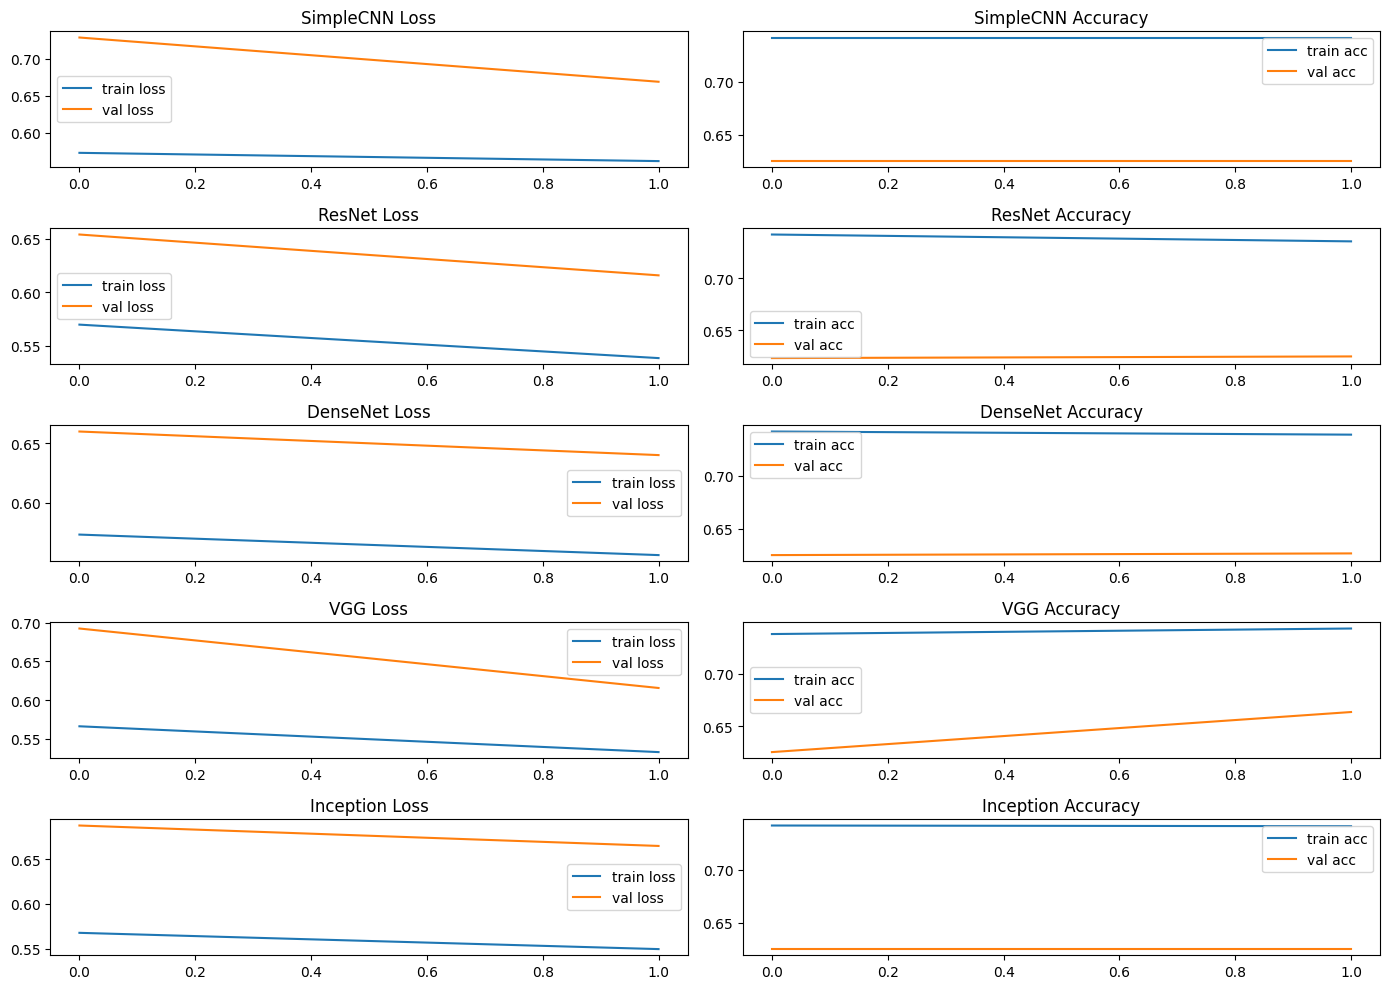

In [ ]:
plt.figure(figsize=(14,10))
i = 1
for name, hist in histories.items():
    plt.subplot(5,2,i); plt.plot(hist.history['loss'], label='train loss')
    if 'val_loss' in hist.history: plt.plot(hist.history['val_loss'], label='val loss')
    plt.title(f"{name} Loss"); plt.legend(); i+=1
    plt.subplot(5,2,i); plt.plot(hist.history.get('accuracy',[]), label='train acc')
    if 'val_accuracy' in hist.history: plt.plot(hist.history.get('val_accuracy',[]), label='val acc')
    plt.title(f"{name} Accuracy"); plt.legend(); i+=1
plt.tight_layout(); plt.show()

In [ ]:
fn_idx = np.where((y_all == 1) & (ensemble_preds == 0))[0]
print("Total false negatives (ensemble):", len(fn_idx))
if len(fn_idx) == 0:
    print("No false negatives to show.")
else:
    # sort by lowest ensemble prob (most confident normal but pneumonia)
    order = np.argsort(ensemble_probs[fn_idx])
    topk = fn_idx[order][:12]
    plt.figure(figsize=(12,6))
    for j, idx in enumerate(topk):
        plt.subplot(3,4,j+1)
        plt.imshow(imgs_all[idx].squeeze(), cmap='gray')
        plt.title(f"Idx:{idx}\nProb:{ensemble_probs[idx]:.2f}")
        plt.axis('off')
    plt.suptitle("Top False Negatives (ensemble)")
    plt.tight_layout(); plt.show()

Total false negatives (ensemble): 0
No false negatives to show.


Grad-CAM examples indices: [102, 435, 270, 106, 71, 20]


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_268']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


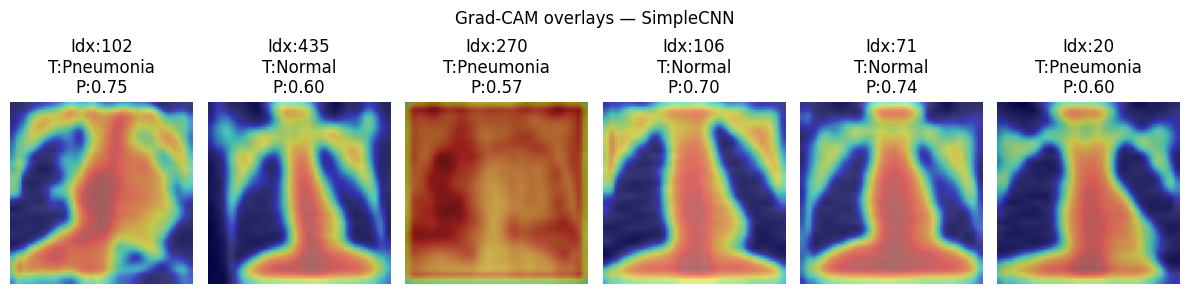

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_295']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


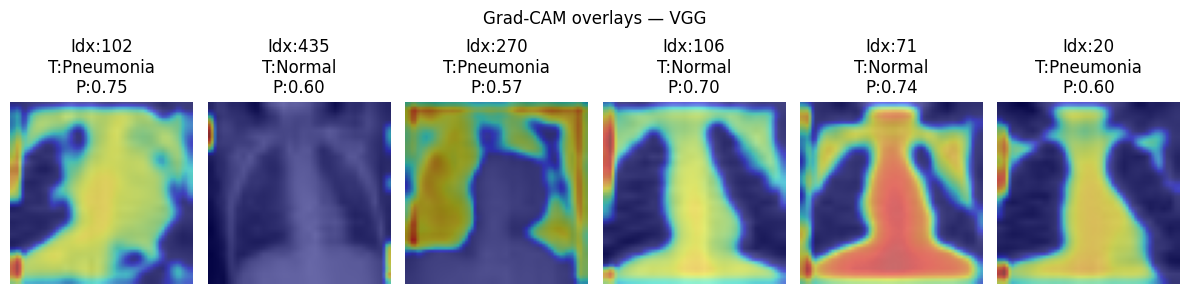

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_275']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


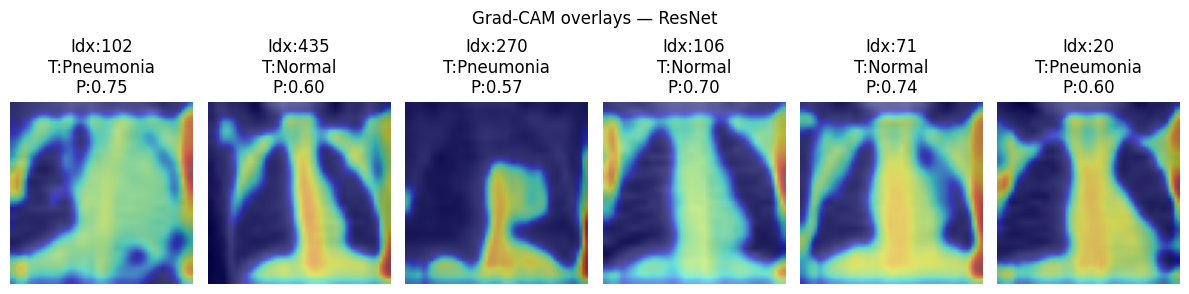

In [ ]:
models_for_cam = ["SimpleCNN","VGG","ResNet"]

selected_idxs = []
if len(fn_idx) > 0:
    selected_idxs.extend(fn_idx[:3])

while len(selected_idxs) < 6:
    candidate = int(np.random.randint(0, N))
    if candidate not in selected_idxs:
        selected_idxs.append(candidate)
selected_idxs = selected_idxs[:6]
print("Grad-CAM examples indices:", selected_idxs)

for model_name in models_for_cam:
    model = models[model_name]
    last_conv = find_last_conv_layer(model)
    if last_conv is None:
        print(f"No conv layer found for {model_name}, skipping Grad-CAM for this model.")
        continue
    plt.figure(figsize=(12,8))
    for i, idx in enumerate(selected_idxs):
        heat = make_gradcam_heatmap(model, imgs_all[idx], last_conv_name=last_conv)

        img = imgs_all[idx].squeeze()
        cmap = plt.get_cmap('jet')
        heat_col = cmap(heat)[:,:,:3]
        img_rgb = np.repeat(img[..., np.newaxis], 3, axis=-1)
        overlay = 0.5 * img_rgb + 0.5 * heat_col
        overlay = np.clip(overlay, 0, 1)
        plt.subplot(3,6,i+1 if False else i+1)
        plt.imshow(overlay)
        title = f"Idx:{idx}\nT:{LABELS[y_all[idx]]}\nP:{ensemble_probs[idx]:.2f}"
        plt.title(title); plt.axis('off')
    plt.suptitle(f"Grad-CAM overlays — {model_name}")
    plt.tight_layout(); plt.show()


Running t-SNE on 300 samples ...


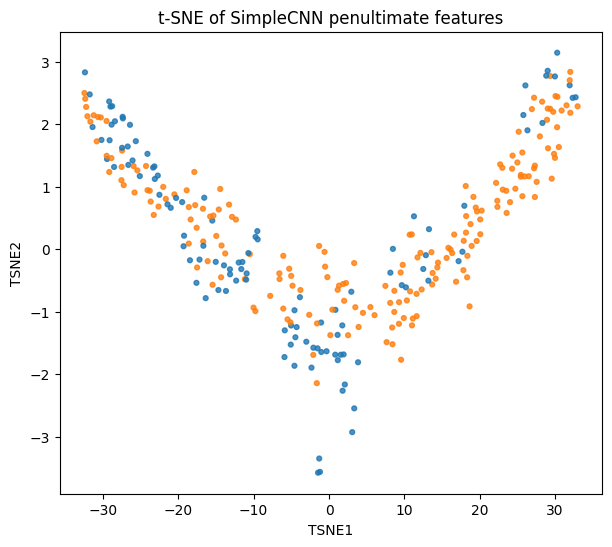

In [ ]:
def extract_penultimate(model, imgs, layer_name='penultimate'):
    inter = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feats = inter.predict(imgs, batch_size=64, verbose=0)
    return feats

# take subset for speed
max_samples = min(300, N)
sel_idx = np.random.choice(np.arange(N), size=max_samples, replace=False)
sel_imgs = imgs_all[sel_idx]
sel_labels = y_all[sel_idx]

feats = extract_penultimate(models["SimpleCNN"], sel_imgs)  # shape (max_samples, dim)
print("Running t-SNE on", feats.shape[0], "samples ...")
tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, init='pca', learning_rate='auto')
feat2d = tsne.fit_transform(feats)

plt.figure(figsize=(7,6))
colors = ['tab:blue' if l==0 else 'tab:orange' for l in sel_labels]
plt.scatter(feat2d[:,0], feat2d[:,1], c=colors, s=12, alpha=0.8)
plt.title("t-SNE of SimpleCNN penultimate features")
plt.xlabel("TSNE1"); plt.ylabel("TSNE2"); plt.show()

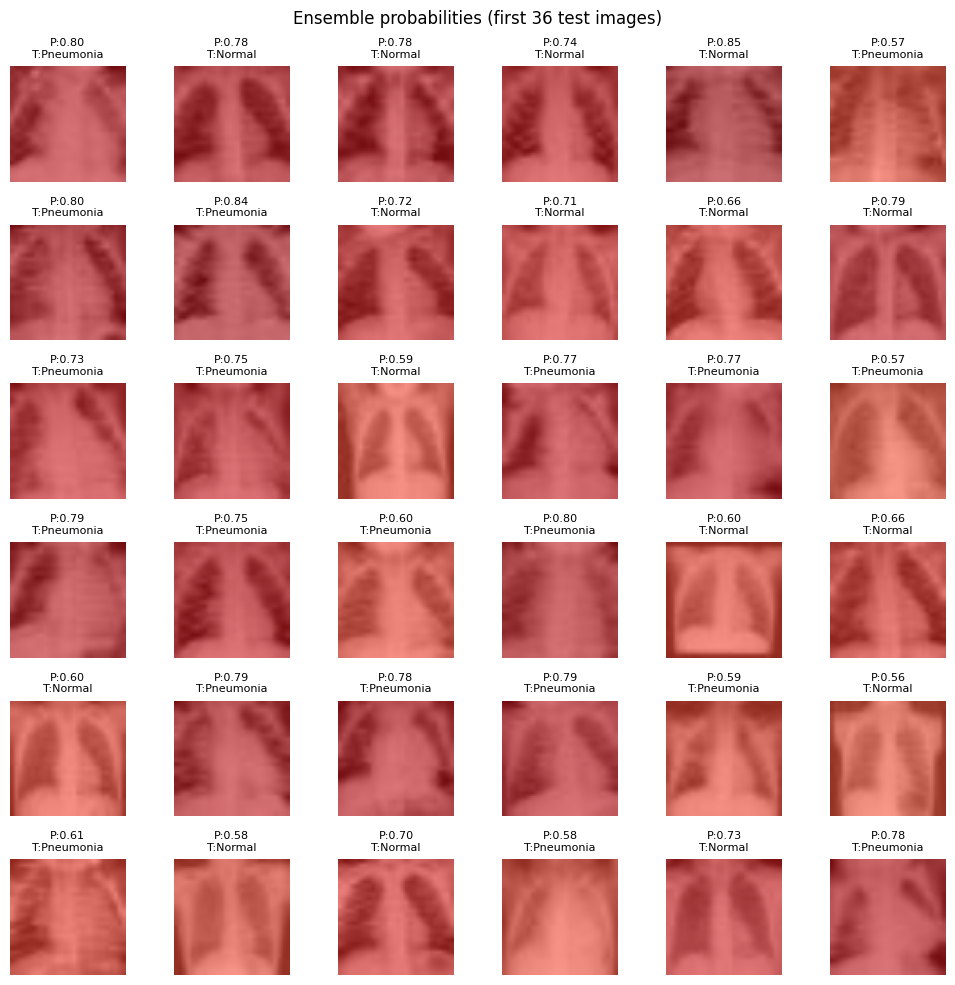

Done — 5 visual outputs displayed: learning curves, FN montage, Grad-CAMs, t-SNE, ensemble heatmap.


In [ ]:
grid_k = min(36, N)
plt.figure(figsize=(10,10))
for i in range(grid_k):
    idx = i
    plt.subplot(6,6,i+1)
    plt.imshow(imgs_all[idx].squeeze(), cmap='gray')
    prob = ensemble_probs[idx]
    plt.title(f"P:{prob:.2f}\nT:{LABELS[y_all[idx]]}", fontsize=8)
    plt.axis('off')
    # add small colored rectangle indicating prob (red=high prob, blue=low)
    plt.gca().add_patch(plt.Rectangle((0,0),2,2, transform=plt.gca().transAxes,
                                     facecolor=plt.cm.Reds(prob), alpha=0.6))
plt.suptitle("Ensemble probabilities (first 36 test images)"); plt.tight_layout(); plt.show()

print("Done — 5 visual outputs displayed: learning curves, FN montage, Grad-CAMs, t-SNE, ensemble heatmap.")